# Ablation Study for Domain-Specific InstructPix2Pix

This standalone notebook reuses the *Final_Project* pipeline (data prep, etc), but runs the ablation study.



In [ ]:
# install packages required
%pip install -q lpips pytorch-msssim

In [ ]:
import os
import gc
import math
import json
import copy
import random
import re
from dataclasses import dataclass, asdict
from typing import Dict, List, Any

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import defaultdict

from datasets import load_dataset
from diffusers import StableDiffusionInstructPix2PixPipeline, DDPMScheduler
from transformers import CLIPProcessor, CLIPModel
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

import lpips
from pytorch_msssim import ssim as ssim_torch

# for replication can remove
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda", "This ablation requires a CUDA-enabled runtime."
print(f"Using device: {device}")


Using device: cuda


In [ ]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

lpips_model = lpips.LPIPS(net='vgg').to(device)
lpips_model.eval()

_to_tensor = transforms.ToTensor()

def pil_to_tensor(image: Image.Image) -> torch.Tensor:
    return _to_tensor(image).unsqueeze(0).to(device)

def _match_image_size(candidate: Image.Image, reference: Image.Image) -> Image.Image:
    if candidate.size != reference.size:
        return candidate.resize(reference.size, Image.Resampling.LANCZOS)
    return candidate

def calculate_lpips(img1: Image.Image, img2: Image.Image) -> float:
    img2_aligned = _match_image_size(img2, img1)
    x = 2 * pil_to_tensor(img1) - 1.0
    y = 2 * pil_to_tensor(img2_aligned) - 1.0
    with torch.no_grad():
        return lpips_model(x, y).item()

def calculate_ssim(img1: Image.Image, img2: Image.Image) -> float:
    img2_aligned = _match_image_size(img2, img1)
    x = pil_to_tensor(img1)
    y = pil_to_tensor(img2_aligned)
    return ssim_torch(x, y, data_range=1.0, size_average=True).item()

def calculate_clip_score(image: Image.Image, text: str) -> float:
    inputs = clip_processor(text=[text], images=image, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = clip_model(**inputs)
        image_embeds = outputs.image_embeds / outputs.image_embeds.norm(dim=-1, keepdim=True)
        text_embeds = outputs.text_embeds / outputs.text_embeds.norm(dim=-1, keepdim=True)
        clip_score = (image_embeds @ text_embeds.T).item()
    return clip_score * 100

def calculate_clip_directional_similarity(original_img, edited_img, text):
    with torch.no_grad():
        inputs_orig = clip_processor(images=original_img, return_tensors="pt").to(device)
        orig_embeds = clip_model.get_image_features(**inputs_orig)
        orig_embeds = orig_embeds / orig_embeds.norm(dim=-1, keepdim=True)

        inputs_edit = clip_processor(images=edited_img, return_tensors="pt").to(device)
        edit_embeds = clip_model.get_image_features(**inputs_edit)
        edit_embeds = edit_embeds / edit_embeds.norm(dim=-1, keepdim=True)

        inputs_text = clip_processor(text=[text], return_tensors="pt", padding=True).to(device)
        text_embeds = clip_model.get_text_features(**inputs_text)
        text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

        img_direction = edit_embeds - orig_embeds
        img_direction = img_direction / (img_direction.norm(dim=-1, keepdim=True) + 1e-8)

        null_text = clip_processor(text=[""], return_tensors="pt", padding=True).to(device)
        null_embeds = clip_model.get_text_features(**null_text)
        null_embeds = null_embeds / null_embeds.norm(dim=-1, keepdim=True)

        text_direction = text_embeds - null_embeds
        text_direction = text_direction / (text_direction.norm(dim=-1, keepdim=True) + 1e-8)

        directional_sim = (img_direction @ text_direction.T).item()
    return directional_sim * 100

print("metric stack ready.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth
Metric stack ready.


In [ ]:
FASHIONPEDIA_STREAM_LIMIT = 100
MAX_TRIPLETS = 1500
IMAGE_SIZE = 512
BATCH_SIZE = 1
CHECKPOINT_DIR = "ablation_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("Loading FashionPedia stream (for qualitative eval)...")
dataset_fashionpedia = load_dataset("detection-datasets/fashionpedia", split="train", streaming=True)
fashionpedia_samples = list(dataset_fashionpedia.take(FASHIONPEDIA_STREAM_LIMIT))
print(f"Loaded {len(fashionpedia_samples)} FashionPedia samples for eval.")

print("Loading DeepFashion2 (with masks) ...")
deepfashion_dataset = load_dataset("SaffalPoosh/deepFashion-with-masks")
print(deepfashion_dataset)


def generate_instruction(caption1: str, caption2: str) -> str:
    part2 = caption2.lower().split("in ")[-1] if "in " in caption2.lower() else caption2.lower()
    return f"change to {part2}"


def build_triplets(hf_dataset, max_triplets: int):
    by_pid = defaultdict(list)
    for i in range(len(hf_dataset["train"])):
        by_pid[hf_dataset["train"][i]["pid"]].append(i)

    triplets = []
    for pid, indices in tqdm(by_pid.items(), desc="Building triplets"):
        if len(indices) < 2:
            continue
        for i in range(len(indices)):
            for j in range(len(indices)):
                if i == j:
                    continue
                triplets.append({"src_idx": indices[i], "tgt_idx": indices[j]})
                if len(triplets) >= max_triplets:
                    return triplets
    return triplets

triplets = build_triplets(deepfashion_dataset, max_triplets=MAX_TRIPLETS)
print(f"Total triplets for ablation: {len(triplets)}")


class TripletDataset(Dataset):
    def __init__(self, triplet_list, hf_data, size=IMAGE_SIZE):
        self.data = triplet_list
        self.hf = hf_data
        self.size = size
        self.transform = transforms.Compose([
            transforms.Resize((size, size), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((size, size), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
        ])
        self.color_jitter = transforms.ColorJitter(0.1, 0.1, 0.1, 0.05)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        t = self.data[idx]
        src = self.hf["train"][t["src_idx"]]
        tgt = self.hf["train"][t["tgt_idx"]]

        orig_img = src["images"].convert("RGB")
        edit_img = tgt["images"].convert("RGB")
        src_mask = src["mask"].convert("L")
        instruction = generate_instruction(src["caption"], tgt["caption"])

        if torch.rand(1).item() < 0.5:
            orig_img = TF.hflip(orig_img)
            edit_img = TF.hflip(edit_img)
            src_mask = TF.hflip(src_mask)

        orig_img = self.color_jitter(orig_img)
        edit_img = self.color_jitter(edit_img)

        conditioning_image = self.transform(orig_img)
        pixel_values = self.transform(edit_img)
        mask_tensor = self.mask_transform(src_mask)
        mask_tensor = (mask_tensor > 0.5).float()

        return {
            "conditioning_image": conditioning_image,
            "pixel_values": pixel_values,
            "prompt": instruction,
            "mask": mask_tensor,
        }

full_ds = TripletDataset(triplets, deepfashion_dataset, size=IMAGE_SIZE)
train_size = int(len(full_ds) * 0.8)
val_size = int(len(full_ds) * 0.1)
test_size = len(full_ds) - train_size - val_size

train_ds, val_ds, test_ds = torch.utils.data.random_split(
    full_ds,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

peek = next(iter(train_loader))
print(f"Conditioning shape: {peek['conditioning_image'].shape}")
print(f"Sample prompt: {peek['prompt'][0]}")


Loading FashionPedia stream (for qualitative eval)...
Loaded 100 FashionPedia samples for eval.
Loading DeepFashion2 (with masks) ...


data/train-00002-of-00004-f11f7b29a225c1(…):   0%|          | 0.00/361M [00:00<?, ?B/s]

data/train-00003-of-00004-e6de6e7287b28c(…):   0%|          | 0.00/361M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40658 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['images', 'gender', 'pose', 'cloth_type', 'pid', 'caption', 'mask', 'mask_overlay'],
        num_rows: 40658
    })
})


Building triplets:   0%|          | 0/7557 [00:00<?, ?it/s]

Total triplets for ablation: 1500
Train: 1200, Val: 150, Test: 150
Conditioning shape: torch.Size([1, 3, 512, 512])
Sample prompt: change to a white shirt and jeans


In [ ]:
ABLATION_EPOCHS = 2
EVAL_PROMPTS = [
    "change to a floral pattern",
    "make the shirt red",
    "add stripes to the clothes",
    "change shirt to blue",
]
NUM_EVAL_IMAGES = 2
FASHIONPEDIA_EVAL_IMAGES = 2

@dataclass
class AblationConfig:
    name: str
    learning_rate: float
    lambda_preserve: float
    guidance_scale: float
    image_guidance_scale: float
    num_inference_steps: int
    unfreeze_strategy: str
    weight_decay: float = 0.01
    max_grad_norm: float = 1.0


def config_slug(name: str) -> str:
    base = name.lower().replace(" ", "_")
    return re.sub(r"[^a-z0-9_]+", "", base) or "config"


def apply_unfreeze_strategy(unet, strategy: str):
    for param in unet.parameters():
        param.requires_grad = False

    trainable_names = []

    def is_attn_proj(name):
        targets = ["to_q", "to_k", "to_v", "to_out"]
        return any(t in name for t in targets)

    for name, param in unet.named_parameters():
        should_train = False
        if "attn" in name and is_attn_proj(name):
            should_train = True
        if "mid_block" in name and strategy in {"attn_mid", "attn_mid_up", "attn_mid_resnet"}:
            should_train = True
        if strategy in {"attn_mid_up", "attn_mid_resnet"} and "up_blocks" in name:
            if "resnets" in name and "conv" in name:
                should_train = True
        if strategy == "attn_mid_resnet" and "down_blocks" in name and "resnets" in name and "conv" in name:
            should_train = True

        if should_train:
            param.requires_grad = True
            trainable_names.append(name)

    return trainable_names


def prepare_components(config: AblationConfig):
    pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
        "timbrooks/instruct-pix2pix",
        torch_dtype=torch.float16,
        safety_checker=None,
    ).to(device)
    pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)

    unet = pipe.unet
    tokenizer = pipe.tokenizer
    text_encoder = pipe.text_encoder
    vae = pipe.vae
    noise_scheduler = pipe.scheduler

    trainable_names = apply_unfreeze_strategy(unet, config.unfreeze_strategy)
    trainable_params = [p for p in unet.parameters() if p.requires_grad]
    optimizer = AdamW(trainable_params, lr=config.learning_rate, eps=1e-4, weight_decay=config.weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=ABLATION_EPOCHS * len(train_loader))

    return {
        "pipe": pipe,
        "unet": unet,
        "tokenizer": tokenizer,
        "text_encoder": text_encoder,
        "vae": vae,
        "noise_scheduler": noise_scheduler,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "trainable_params": trainable_params,
        "trainable_names": trainable_names,
    }


def encode_prompt(tokenizer, text_encoder, texts):
    tokens = tokenizer(
        list(texts),
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    ).input_ids.to(device)
    with torch.no_grad():
        text_embeds = text_encoder(tokens)[0]
    return text_embeds


def encode_vae_images(vae, images):
    images = images.to(device, dtype=torch.float16)
    with torch.no_grad():
        latents = vae.encode(images).latent_dist.sample()
    return latents * vae.config.scaling_factor


def train_one_epoch(config, components):
    unet = components["unet"]
    vae = components["vae"]
    tokenizer = components["tokenizer"]
    text_encoder = components["text_encoder"]
    noise_scheduler = components["noise_scheduler"]
    optimizer = components["optimizer"]
    scheduler = components["scheduler"]
    trainable_params = components["trainable_params"]

    unet.train()
    epoch_losses = []
    progress = tqdm(train_loader, desc=f"{config.name} — train", leave=False)
    for batch in progress:
        pixel_values = batch["pixel_values"].to(device, dtype=torch.float16)
        cond_images = batch["conditioning_image"].to(device, dtype=torch.float16)
        masks = batch["mask"].to(device, dtype=torch.float16)
        prompts = batch["prompt"]

        with torch.no_grad():
            target_latents = encode_vae_images(vae, pixel_values)
            cond_latents = encode_vae_images(vae, cond_images)
            mask_latent = F.interpolate(masks, size=target_latents.shape[-2:], mode="nearest")
            mask_latent = mask_latent.expand(-1, 4, -1, -1)

        noise = torch.randn_like(target_latents)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps,
                                  (target_latents.shape[0],), device=device, dtype=torch.long)
        noisy_latents = noise_scheduler.add_noise(target_latents, noise, timesteps)
        model_input = torch.cat([noisy_latents, cond_latents], dim=1)
        text_embeds = encode_prompt(tokenizer, text_encoder, prompts)

        optimizer.zero_grad()
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            noise_pred = unet(model_input, timesteps, encoder_hidden_states=text_embeds, return_dict=False)[0]

        M_cloth = mask_latent
        M_bg = 1.0 - mask_latent
        L_denoise = F.mse_loss((noise_pred * M_cloth).float(), (noise * M_cloth).float())
        L_preserve = F.mse_loss((noise_pred * M_bg).float(), (noise * M_bg).float())
        loss = L_denoise + config.lambda_preserve * L_preserve

        if not torch.isfinite(loss):
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(trainable_params, config.max_grad_norm)
        optimizer.step()
        scheduler.step()

        epoch_losses.append(loss.item())
        progress.set_postfix({"loss": f"{loss.item():.4f}", "lr": f"{scheduler.get_last_lr()[0]:.2e}"})

    avg_loss = float(np.mean(epoch_losses)) if epoch_losses else float("nan")
    return avg_loss


def validate_one_epoch(config, components, max_batches=50):
    unet = components["unet"]
    vae = components["vae"]
    tokenizer = components["tokenizer"]
    text_encoder = components["text_encoder"]
    noise_scheduler = components["noise_scheduler"]

    unet.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            if batch_idx >= max_batches:
                break
            pixel_values = batch["pixel_values"].to(device, dtype=torch.float16)
            cond_images = batch["conditioning_image"].to(device, dtype=torch.float16)
            masks = batch["mask"].to(device, dtype=torch.float16)
            prompts = batch["prompt"]

            target_latents = encode_vae_images(vae, pixel_values)
            cond_latents = encode_vae_images(vae, cond_images)
            mask_latent = F.interpolate(masks, size=target_latents.shape[-2:], mode="nearest")
            mask_latent = mask_latent.expand(-1, 4, -1, -1)

            noise = torch.randn_like(target_latents)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps,
                                      (target_latents.shape[0],), device=device, dtype=torch.long)
            noisy_latents = noise_scheduler.add_noise(target_latents, noise, timesteps)
            model_input = torch.cat([noisy_latents, cond_latents], dim=1)
            text_embeds = encode_prompt(tokenizer, text_encoder, prompts)

            with torch.autocast(device_type="cuda", dtype=torch.float16):
                noise_pred = unet(model_input, timesteps, encoder_hidden_states=text_embeds, return_dict=False)[0]

            M_cloth = mask_latent
            M_bg = 1.0 - mask_latent
            L_denoise = F.mse_loss((noise_pred * M_cloth).float(), (noise * M_cloth).float())
            L_preserve = F.mse_loss((noise_pred * M_bg).float(), (noise * M_bg).float())
            loss = L_denoise + config.lambda_preserve * L_preserve
            val_losses.append(loss.item())

    avg_val = float(np.mean(val_losses)) if val_losses else float("nan")
    unet.train()
    return avg_val


def evaluate_config(pipe, config: AblationConfig):
    pipe.unet.eval()
    deepfashion_rows = []
    fashionpedia_rows = []
    deepfashion_visuals = []
    fashionpedia_visuals = []

    for row in range(NUM_EVAL_IMAGES):
        actual_idx = test_ds.indices[row % len(test_ds)]
        triplet = triplets[actual_idx]
        src = deepfashion_dataset["train"][triplet["src_idx"]]
        original_image = src["images"]
        if max(original_image.size) > 512:
            original_image = original_image.copy()
            original_image.thumbnail((512, 512), Image.Resampling.LANCZOS)

        row_visual = {"original": original_image.copy(), "edits": []}
        for prompt in EVAL_PROMPTS:
            with torch.autocast("cuda"):
                edited = pipe(
                    prompt=prompt,
                    image=original_image,
                    num_inference_steps=config.num_inference_steps,
                    guidance_scale=config.guidance_scale,
                    image_guidance_scale=config.image_guidance_scale,
                ).images[0]
            clip_score = calculate_clip_score(edited, prompt)
            dir_sim = calculate_clip_directional_similarity(original_image, edited, prompt)
            lpips_val = calculate_lpips(original_image, edited)
            ssim_val = calculate_ssim(original_image, edited)
            deepfashion_rows.append({
                "config": config.name,
                "dataset": "DeepFashion2",
                "row": row,
                "prompt": prompt,
                "clip_score": clip_score,
                "directional_similarity": dir_sim,
                "lpips": lpips_val,
                "ssim": ssim_val,
            })
            row_visual["edits"].append({"prompt": prompt, "image": edited.copy(), "clip": clip_score, "dir": dir_sim})
        deepfashion_visuals.append(row_visual)

    for row in range(FASHIONPEDIA_EVAL_IMAGES):
        sample = fashionpedia_samples[row]
        original_image = sample['image']
        if max(original_image.size) > 512:
            original_image = original_image.copy()
            original_image.thumbnail((512, 512), Image.Resampling.LANCZOS)

        row_visual = {"original": original_image.copy(), "edits": []}
        for prompt in EVAL_PROMPTS:
            with torch.autocast("cuda"):
                edited = pipe(
                    prompt=prompt,
                    image=original_image,
                    num_inference_steps=config.num_inference_steps,
                    guidance_scale=config.guidance_scale,
                    image_guidance_scale=config.image_guidance_scale,
                ).images[0]
            clip_score = calculate_clip_score(edited, prompt)
            dir_sim = calculate_clip_directional_similarity(original_image, edited, prompt)
            lpips_val = calculate_lpips(original_image, edited)
            ssim_val = calculate_ssim(original_image, edited)
            fashionpedia_rows.append({
                "config": config.name,
                "dataset": "FashionPedia",
                "row": row,
                "prompt": prompt,
                "clip_score": clip_score,
                "directional_similarity": dir_sim,
                "lpips": lpips_val,
                "ssim": ssim_val,
            })
            row_visual["edits"].append({"prompt": prompt, "image": edited.copy(), "clip": clip_score, "dir": dir_sim})
        fashionpedia_visuals.append(row_visual)

    return {
        "deepfashion_metrics": pd.DataFrame(deepfashion_rows),
        "fashionpedia_metrics": pd.DataFrame(fashionpedia_rows),
        "deepfashion_visuals": deepfashion_visuals,
        "fashionpedia_visuals": fashionpedia_visuals,
    }



In [ ]:
ABLATION_CONFIGS = [
    AblationConfig(
        name="A: λ0.5, lr1e-5, attn+mid+up",
        learning_rate=1e-5,
        lambda_preserve=0.5,
        guidance_scale=7.5,
        image_guidance_scale=1.5,
        num_inference_steps=40,
        unfreeze_strategy="attn_mid_up",
    ),
    AblationConfig(
        name="B: λ0.8, lr2e-5, attn+mid+up",
        learning_rate=2e-5,
        lambda_preserve=0.8,
        guidance_scale=8.0,
        image_guidance_scale=1.7,
        num_inference_steps=50,
        unfreeze_strategy="attn_mid_up",
    ),
    AblationConfig(
        name="C: λ0.3, lr5e-6, attn+mid",
        learning_rate=5e-6,
        lambda_preserve=0.3,
        guidance_scale=6.5,
        image_guidance_scale=1.3,
        num_inference_steps=35,
        unfreeze_strategy="attn_mid",
    ),
    AblationConfig(
        name="D: λ0.5, lr1e-5, attn+mid+res",
        learning_rate=1e-5,
        lambda_preserve=0.5,
        guidance_scale=7.0,
        image_guidance_scale=1.4,
        num_inference_steps=40,
        unfreeze_strategy="attn_mid_resnet",
    ),
]

ablation_runs: List[Dict[str, Any]] = []

for cfg in ABLATION_CONFIGS:
    print(f"\n===== Running ablation: {cfg.name} =====")
    components = prepare_components(cfg)
    trainable_count = sum(p.numel() for p in components["trainable_params"])

    history = []
    for epoch in range(ABLATION_EPOCHS):
        train_loss = train_one_epoch(cfg, components)
        val_loss = validate_one_epoch(cfg, components, max_batches=len(val_loader))
        history.append({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})
        print(f"Epoch {epoch+1}/{ABLATION_EPOCHS} — train: {train_loss:.4f}, val: {val_loss:.4f}")

        ckpt_path = os.path.join(CHECKPOINT_DIR, f"{config_slug(cfg.name)}_epoch{epoch+1}.pt")
        torch.save({
            "config": asdict(cfg),
            "epoch": epoch + 1,
            "unet_state_dict": components["unet"].state_dict(),
            "optimizer_state_dict": components["optimizer"].state_dict(),
            "scheduler_state_dict": components["scheduler"].state_dict(),
        }, ckpt_path)
        print(f"  ↳ checkpoint saved to {ckpt_path}")

    eval_artifacts = evaluate_config(components["pipe"], cfg)

    run_summary = {
        "config": asdict(cfg),
        "history": history,
        "trainable_params": trainable_count,
        "deepfashion_metrics": eval_artifacts["deepfashion_metrics"],
        "fashionpedia_metrics": eval_artifacts["fashionpedia_metrics"],
        "deepfashion_visuals": eval_artifacts["deepfashion_visuals"],
        "fashionpedia_visuals": eval_artifacts["fashionpedia_visuals"],
    }
    ablation_runs.append(run_summary)

    del components["pipe"]
    del components
    torch.cuda.empty_cache()
    gc.collect()



===== Running ablation: A: λ0.5, lr1e-5, attn+mid+up =====


model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


A: λ0.5, lr1e-5, attn+mid+up — train:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 1/2 — train: 0.0405, val: 0.0433
  ↳ checkpoint saved to ablation_checkpoints/a_05_lr1e5_attnmidup_epoch1.pt


A: λ0.5, lr1e-5, attn+mid+up — train:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 2/2 — train: 0.0412, val: 0.0400
  ↳ checkpoint saved to ablation_checkpoints/a_05_lr1e5_attnmidup_epoch2.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]


===== Running ablation: B: λ0.8, lr2e-5, attn+mid+up =====


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

B: λ0.8, lr2e-5, attn+mid+up — train:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 1/2 — train: 0.0513, val: 0.0484
  ↳ checkpoint saved to ablation_checkpoints/b_08_lr2e5_attnmidup_epoch1.pt


B: λ0.8, lr2e-5, attn+mid+up — train:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 2/2 — train: 0.0524, val: 0.0545
  ↳ checkpoint saved to ablation_checkpoints/b_08_lr2e5_attnmidup_epoch2.pt


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


===== Running ablation: C: λ0.3, lr5e-6, attn+mid =====


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

C: λ0.3, lr5e-6, attn+mid — train:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 1/2 — train: 0.0345, val: 0.0355
  ↳ checkpoint saved to ablation_checkpoints/c_03_lr5e6_attnmid_epoch1.pt


C: λ0.3, lr5e-6, attn+mid — train:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 2/2 — train: 0.0354, val: 0.0333
  ↳ checkpoint saved to ablation_checkpoints/c_03_lr5e6_attnmid_epoch2.pt


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]


===== Running ablation: D: λ0.5, lr1e-5, attn+mid+res =====


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

D: λ0.5, lr1e-5, attn+mid+res — train:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 1/2 — train: 0.0415, val: 0.0396
  ↳ checkpoint saved to ablation_checkpoints/d_05_lr1e5_attnmidres_epoch1.pt


D: λ0.5, lr1e-5, attn+mid+res — train:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 2/2 — train: 0.0418, val: 0.0417
  ↳ checkpoint saved to ablation_checkpoints/d_05_lr1e5_attnmidres_epoch2.pt


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]


All four ablation runs completed.


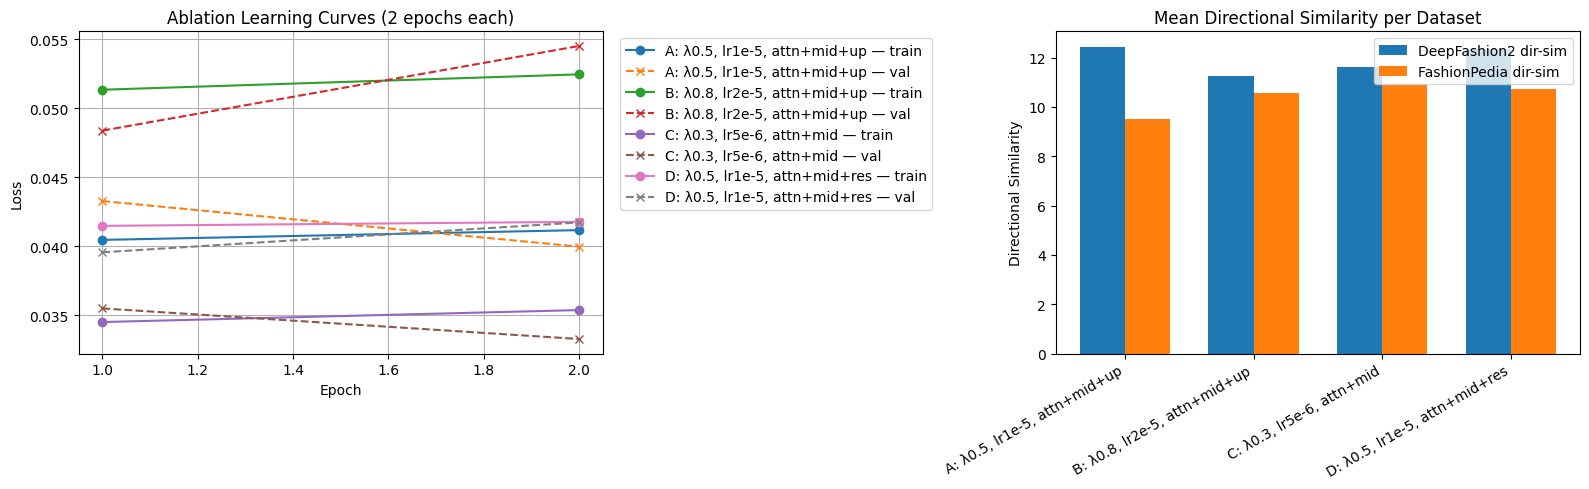

Metric summary (CLIP / DirSim / LPIPS / SSIM):


config       dataset  clip_score  \
0   A: λ0.5, lr1e-5, attn+mid+up  DeepFashion2   20.509795   
1   A: λ0.5, lr1e-5, attn+mid+up  FashionPedia   19.427384   
2   B: λ0.8, lr2e-5, attn+mid+up  DeepFashion2   20.870804   
3   B: λ0.8, lr2e-5, attn+mid+up  FashionPedia   19.699326   
4      C: λ0.3, lr5e-6, attn+mid  DeepFashion2   21.855139   
5      C: λ0.3, lr5e-6, attn+mid  FashionPedia   20.084592   
6  D: λ0.5, lr1e-5, attn+mid+res  DeepFashion2   21.722468   
7  D: λ0.5, lr1e-5, attn+mid+res  FashionPedia   20.142740   

   directional_similarity     lpips      ssim  
0               12.442044  0.355809  0.495023  
1                9.522973  0.408848  0.487818  
2               11.254064  0.270278  0.554784  
3               10.573883  0.364491  0.528399  
4               11.615444  0.331672  0.483953  
5               10.888882  0.399855  0.485995  
6               12.338617  0.296990  0.492303  
7               10.744428  0.377625  0.515408

In [ ]:
history_rows = []
all_metrics_rows = []
for run in ablation_runs:
    cfg_name = run["config"]["name"]
    for entry in run["history"]:
        history_rows.append({"config": cfg_name, **entry})
    all_metrics_rows.append(run["deepfashion_metrics"])
    all_metrics_rows.append(run["fashionpedia_metrics"])

history_df = pd.DataFrame(history_rows)
metrics_df = pd.concat(all_metrics_rows, ignore_index=True)
metric_cols = ["clip_score", "directional_similarity", "lpips", "ssim"]
numeric_metrics = metrics_df[["config", "dataset"] + metric_cols].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for cfg_name, group in history_df.groupby("config"):
    axes[0].plot(group["epoch"], group["train_loss"], marker='o', label=f"{cfg_name} — train")
    axes[0].plot(group["epoch"], group["val_loss"], marker='x', linestyle='--', label=f"{cfg_name} — val")
axes[0].set_title("Ablation Learning Curves (2 epochs each)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid(True)
axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

agg = numeric_metrics.groupby(["config", "dataset"], as_index=False)[metric_cols].mean()
configs = [run["config"]["name"] for run in ablation_runs]
x = np.arange(len(configs))
width = 0.35

for idx, dataset in enumerate(["DeepFashion2", "FashionPedia"]):
    subset = agg[agg["dataset"] == dataset].set_index("config")
    scores = [subset.loc[cfg, "directional_similarity"] for cfg in configs]
    axes[1].bar(x + (idx - 0.5) * width, scores, width=width, label=f"{dataset} dir-sim")

axes[1].set_title("mean Directional Similarity per Dataset")
axes[1].set_xticks(x)
axes[1].set_xticklabels(configs, rotation=30, ha='right')
axes[1].set_ylabel("Directional Similarity")
axes[1].legend()
plt.tight_layout()
plt.show()

print("Metric summary (CLIP / DirSim / LPIPS / SSIM):")
display(agg[["config", "dataset"] + metric_cols])


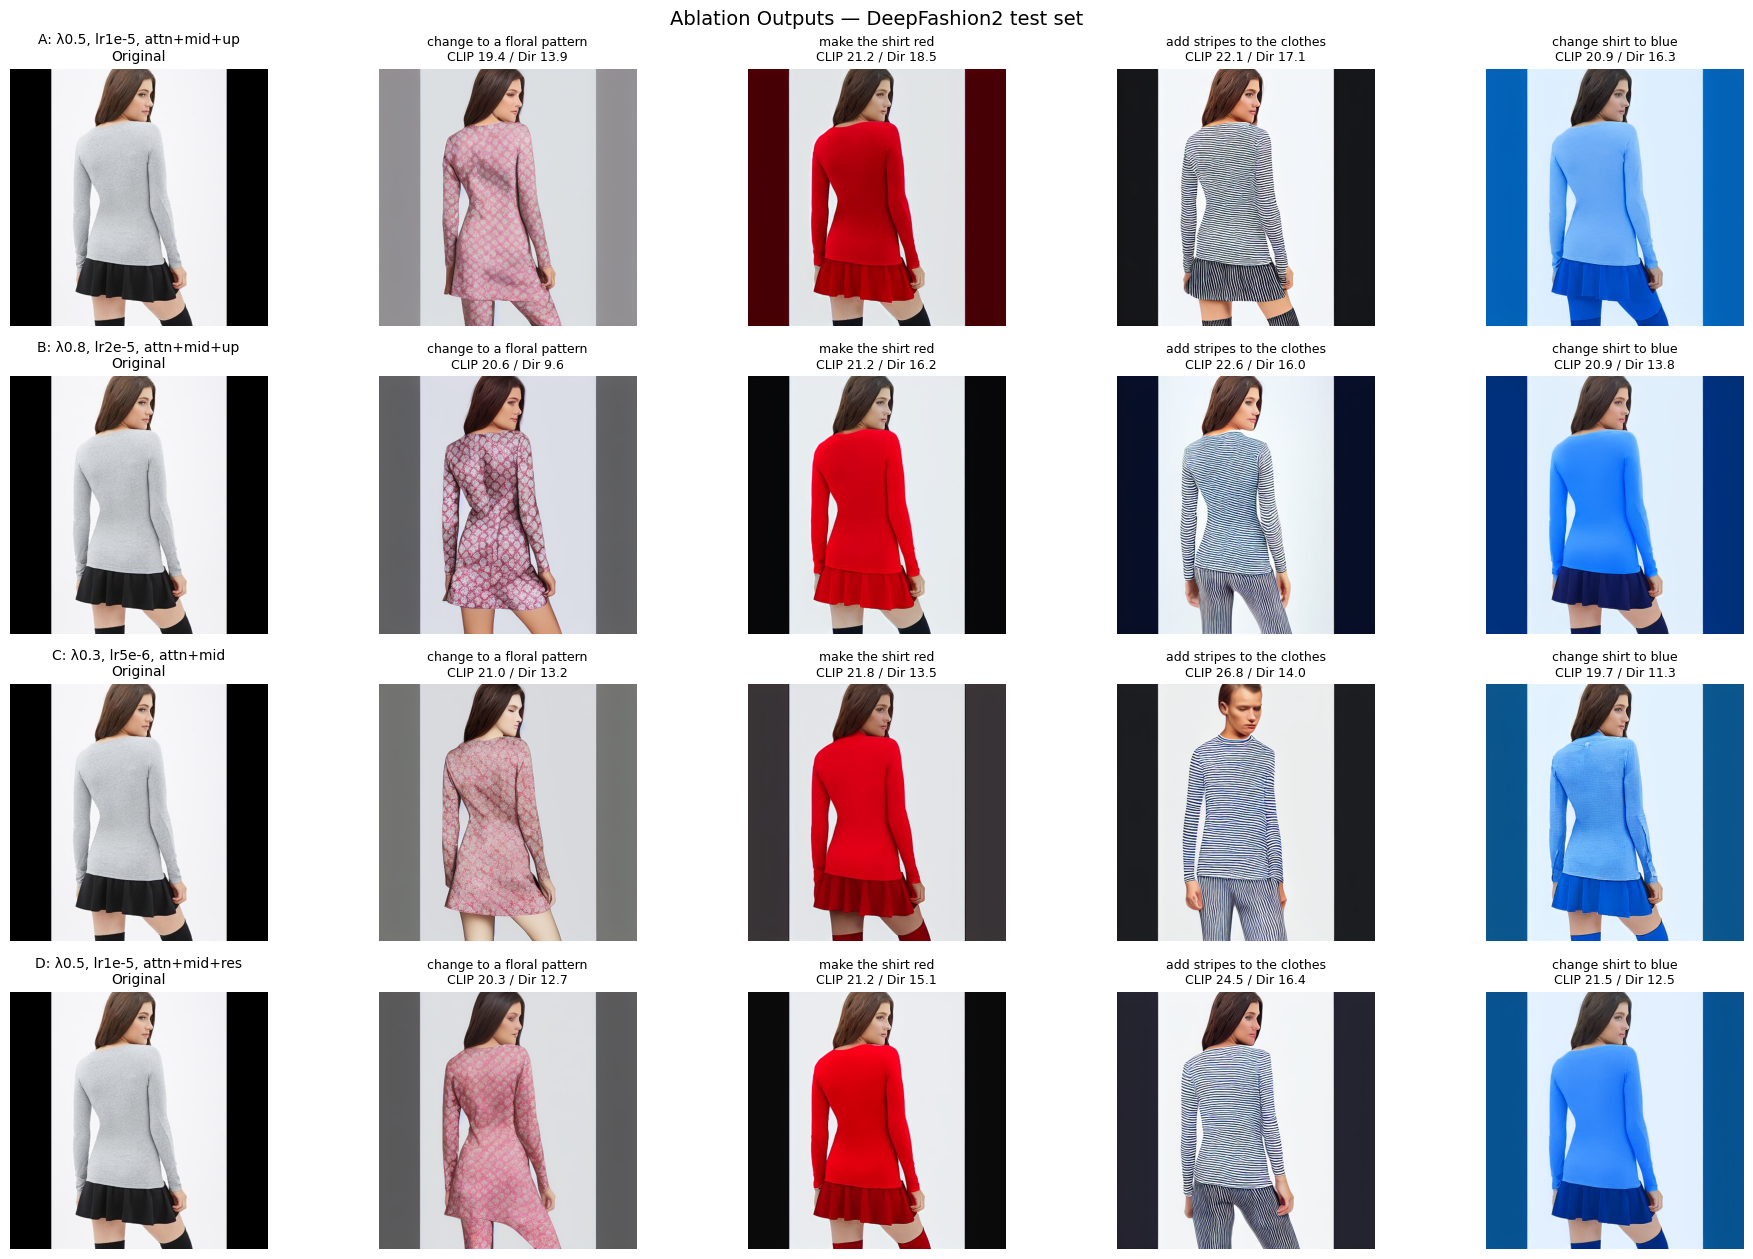

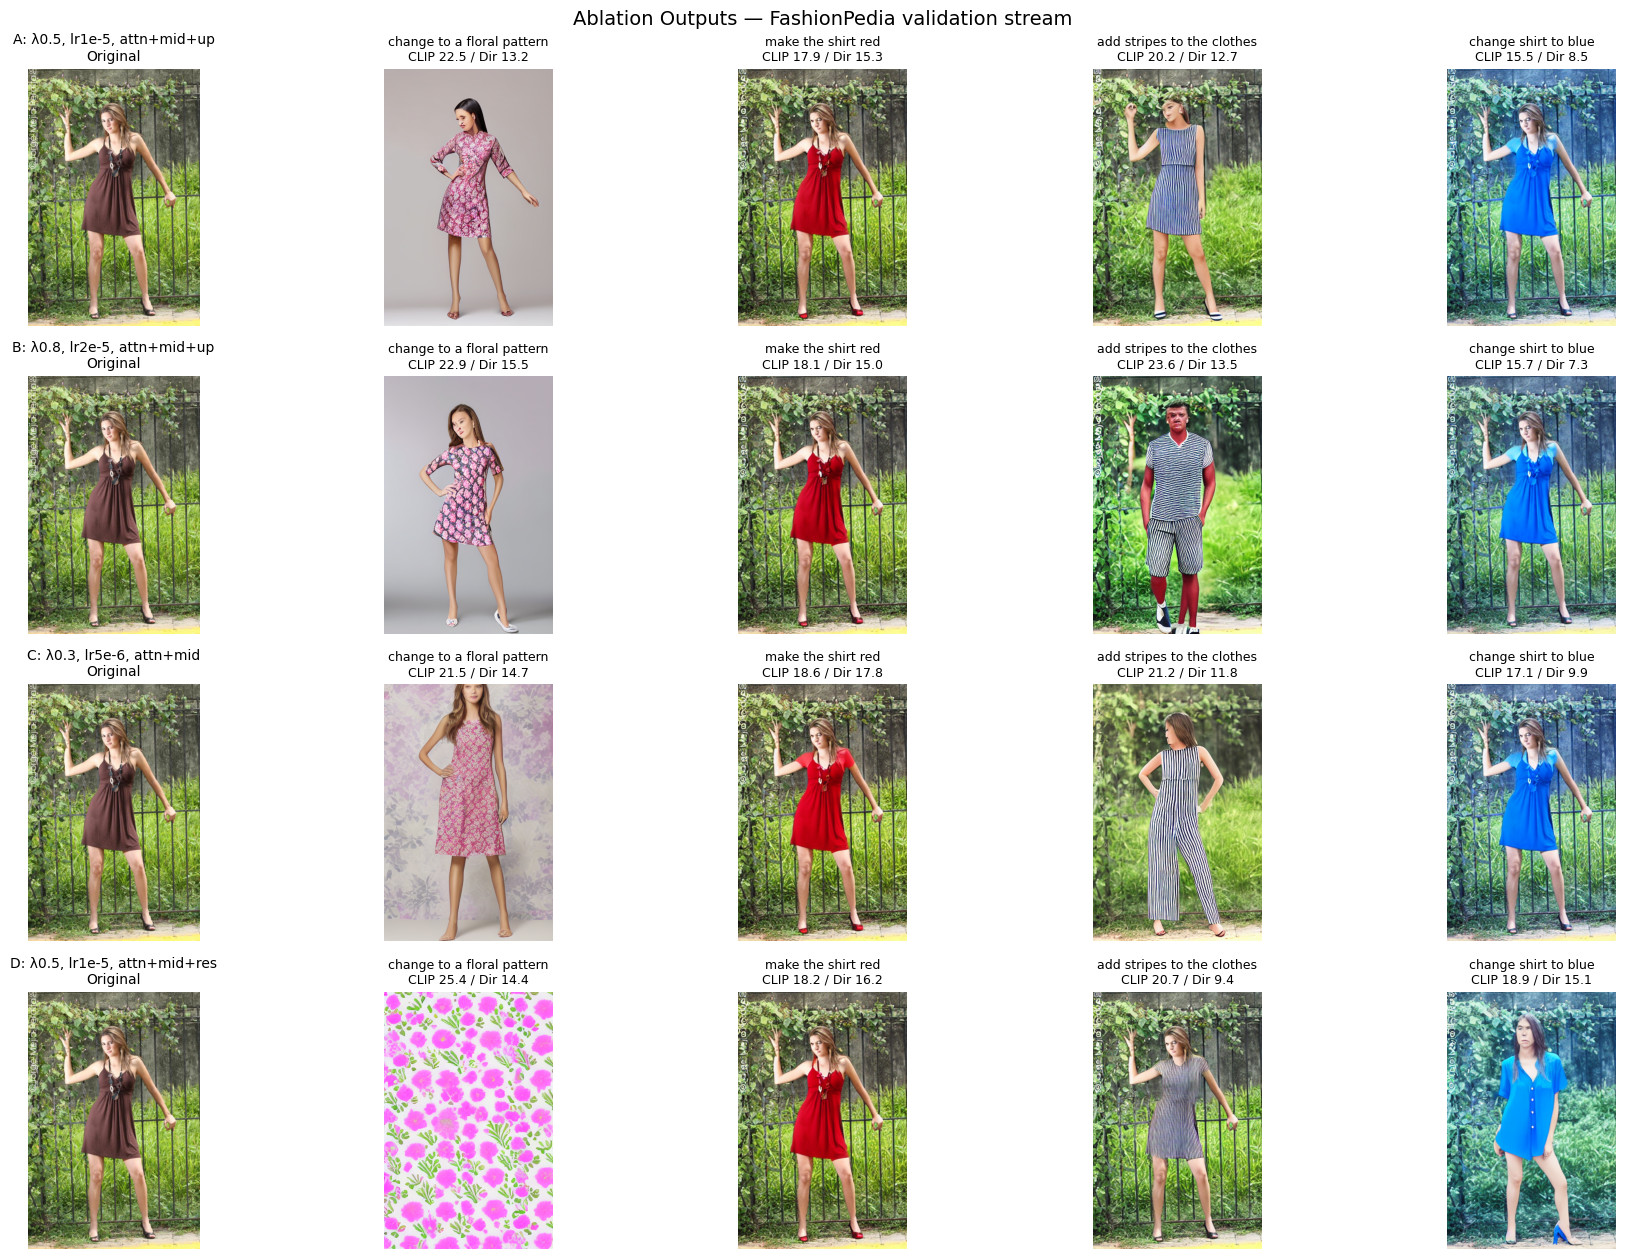

In [ ]:
# === Visualization Set 2: qualitative grids for both datasets ===
def plot_dataset_grid(runs, key, title):
    rows = len(runs)
    cols = len(EVAL_PROMPTS) + 1
    fig, axes = plt.subplots(rows, cols, figsize=(3.8 * cols, 3.2 * rows))
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, run in enumerate(runs):
        cfg_name = run["config"]["name"]
        sample_row = run[key][0]
        axes[r, 0].imshow(sample_row["original"])
        axes[r, 0].set_title(f"{cfg_name}\nOriginal", fontsize=10)
        axes[r, 0].axis('off')
        for c, edit in enumerate(sample_row["edits"], start=1):
            axes[r, c].imshow(edit["image"])
            axes[r, c].set_title(f"{edit['prompt']}\nCLIP {edit['clip']:.1f} / Dir {edit['dir']:.1f}", fontsize=9)
            axes[r, c].axis('off')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

plot_dataset_grid(ablation_runs, "deepfashion_visuals", "Ablation Outputs — DeepFashion2 test set")
plot_dataset_grid(ablation_runs, "fashionpedia_visuals", "Ablation Outputs — FashionPedia validation stream")

## Notes & Usage
- Each ablation run reuses the same DeepFashion2 triplets, dataloaders, and CLIP/LpIPS metrics from `Final_Project.ipynb`.
- Training is fixed to **2 epochs** per configuration as requested; tweak `ABLATION_EPOCHS` if you need longer schedules.
- The visualization blocks at the end produce the two required output sets (learning/metric curves and qualitative grids for DeepFashion2 + FashionPedia).
- If GPU memory is tight, lower `MAX_TRIPLETS`, `IMAGE_SIZE`, or comment out some configs in `ABLATION_CONFIGS`.
- All intermediate metrics remain in the `ablation_runs` list, so you can serialize them to disk (e.g., `json.dump`) or export to CSV for reporting.

